# Example Notebook for Number Squeezing

In [1]:
import pennylane as qml
import numpy as np
import matplotlib.pyplot as plt

import strawberryfields as sf
from strawberryfields import ops

from scipy.optimize import curve_fit

import pandas as pd

%config InlineBackend.figure_format='retina'

We first want to look at what we are trying to reproduce with pennylane. The graph below is from a [paper](https://arxiv.org/abs/1507.03782) by Helmut Strobel. In this paper the collective spin of a Bose-Einstein-Condensate is used to observe nonlinearity in spin squeezing. This notebook aims to simulate the experimental results using pennylane.

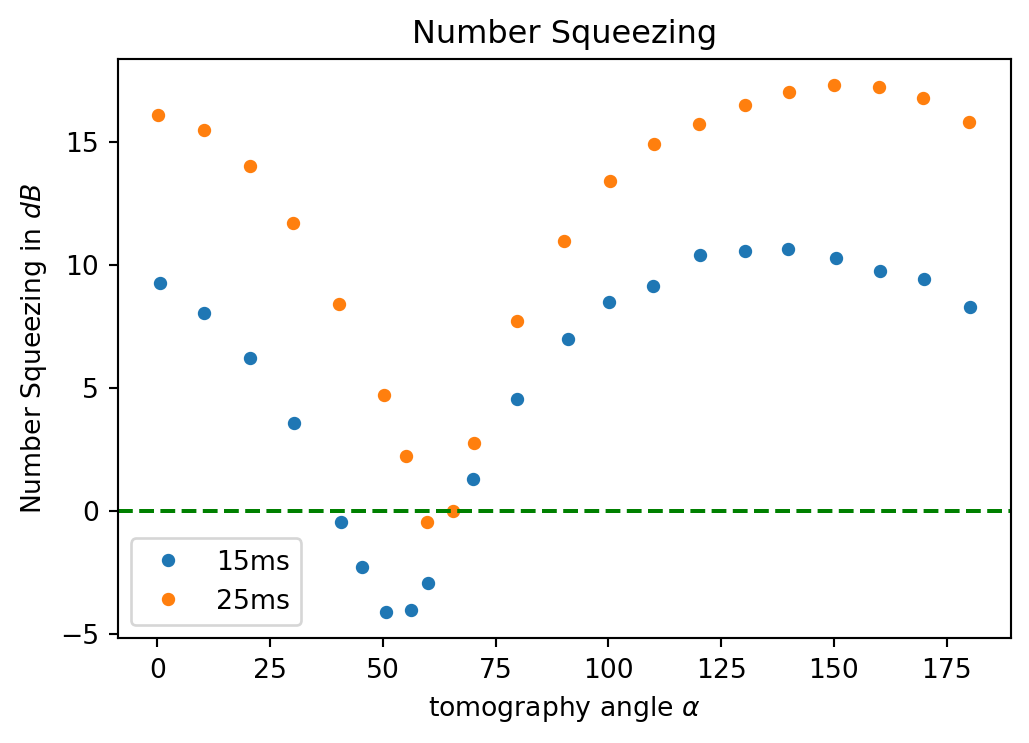

In [2]:
data_strobel_15 = pd.read_csv('Data/Strobel_Data_15ms.csv', names = ['dB', "alpha"])
data_strobel_25 = pd.read_csv('Data/Strobel_Data_25ms.csv', names = ['dB', "alpha"])

plt.figure(dpi=96)
plt.title("Number Squeezing")
plt.plot(data_strobel_15.dB, data_strobel_15.alpha, 'o', label="15ms", markersize=4)
plt.plot(data_strobel_25.dB, data_strobel_25.alpha, 'o', label="25ms", markersize=4)
plt.axhline(y=0, color='g', linestyle='--')
plt.ylabel(r'Number Squeezing in $dB$')
plt.xlabel(r'tomography angle $\alpha$')
_ = plt.legend()

This number squeezing is achieved by performing the following Bloch-sphere rotations. 

We prepare the collective spin such that the Bloch-sphere-vector points to one of the poles. 

#### First step
As a first step the vector is rotated onto the equator.
<center><img width="200" height="300" src="Bloch_spheres/1.png"><\center>

#### Second step
Then the state is being squeezed, such that it starts to wrap around the Bloch-sphere.
    
<center><img width="200" height="300" src="Bloch_spheres/2.png"><\center>

#### Third step   
In the last step we rotate the state around the $X$-axis. This rotation corresponds to the angle $\alpha$ in this notebook.
    
<center>
<img width="300" height="400" src="Bloch_spheres/alpha.png">
<\center>

# the pennylane approach

In [54]:
import pennylane as qml
import numpy as np
import sys

In [55]:
import sys
sys.path.append('../')

In [56]:
from pennylane_ls import *

In [57]:
from heroku_credentials import username, password

In [74]:
nshots = 50
testDevice = SingleQuditDevice(shots = nshots, username = username, password = password)

In [64]:
testDevice.operations

{'load', 'rLx', 'rLz', 'rLz2'}

we now define the quantum circuit that implements the experimental sequence

In [65]:
@qml.qnode(testDevice)
def quantum_circuit(Nat = 10, theta = 0, kappa = 0, alpha=0, Ntrott = 2):
    '''
    The circuit that simulates the experiments.
    
    theta ... angle of the Lx term in the Hamiltonian evolution
    kappa ... angle of the Lz^2 term in the Hamiltonian evolution
    apla ... angle of rotation
    '''
    # load atoms
    load(Nat,wires=0)
    
    # rotate onto x
    rLx(np.pi/2,wires=0)
    rLz(np.pi/2,wires=0)
    
    # evolution under the Hamiltonian
    for ii in range(Ntrott):
        rLx(theta/Ntrott, wires=0)
        rLz2(kappa/Ntrott, wires=0)

    # and the final rotation to test the variance
    rLx(alpha, wires=0)
    return qml.var(Lz(0))

In [88]:
Nat = 200;
l = Nat/2 # spin length
omegax = 2*np.pi*20;
t1 = 15e-3;
t2 = 25e-3;
Lambda = 1.5;#1.5

chi = Lambda*omegax/Nat;

Ntrott = 12;

In [89]:
alphas = np.linspace(0, np.pi, 15)
shots_1 = np.zeros((len(alphas), nshots))

theta1 = omegax*t1/2

kappa1 = chi*t1

for i in range(len(alphas)):
    if i%10==0:
        print("step", i)
    # Calculate the resulting states after each rotation
    shots_1[i] = quantum_circuit(Nat, theta1, kappa1, alphas[i],Ntrott)
    
variances_1 = shots_1.var(axis=1)

step 0
step 10


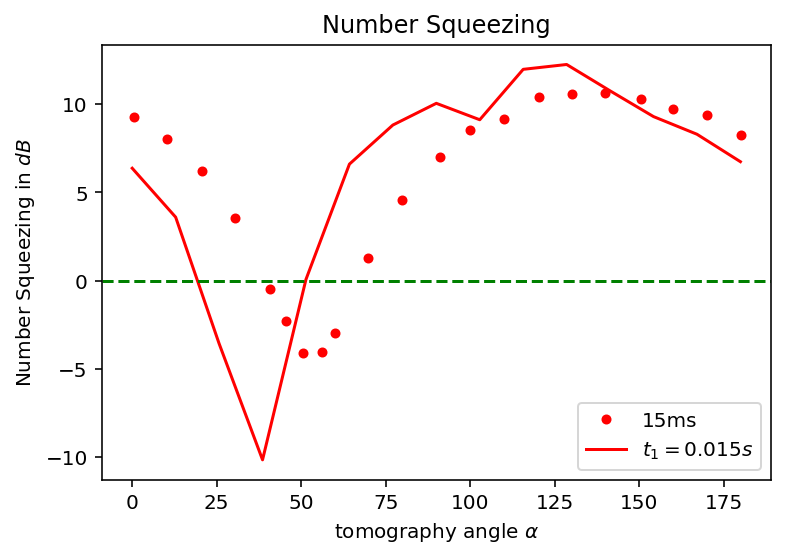

In [90]:
f, ax = plt.subplots()
ax.set_title("Number Squeezing")
ax.plot(data_strobel_15.dB, data_strobel_15.alpha, 'ro', label="15ms", markersize=4)
plt.plot(180-np.rad2deg(alphas), number_squeezing_factor_to_db(l/2, variances_1),'r-', label=fr"$t_1={t1}s$")
ax.axhline(y=0, color='g', linestyle='--')
ax.set_ylabel(r'Number Squeezing in $dB$')
ax.set_xlabel(r'tomography angle $\alpha$')
ax.legend()

In [91]:
print(quantum_circuit.draw())

 0: ──load(200)──rLx(1.57)──rLz(1.57)──rLx(0.0785)──rLz2(0.00118)──rLx(0.0785)──rLz2(0.00118)──rLx(0.0785)──rLz2(0.00118)──rLx(0.0785)──rLz2(0.00118)──rLx(0.0785)──rLz2(0.00118)──rLx(0.0785)──rLz2(0.00118)──rLx(0.0785)──rLz2(0.00118)──rLx(0.0785)──rLz2(0.00118)──rLx(0.0785)──rLz2(0.00118)──rLx(0.0785)──rLz2(0.00118)──rLx(0.0785)──rLz2(0.00118)──rLx(0.0785)──rLz2(0.00118)──rLx(3.14)──┤ Sample[Lz] 



# The approach with exact matrices.

In [4]:
from scipy.sparse.linalg import expm
from scipy.sparse import coo_matrix, csc_matrix, diags, identity

import qutip as q
from qutip import Qobj

In [5]:
l = Nat/2 # spin length

# let's put together spin matrices
dim_qudit = 2*l+1
qudit_range = np.arange(l, -(l+1),-1)

Id  =  csc_matrix(identity(dim_qudit))
Lx  =  csc_matrix(1/2*diags([np.sqrt([(l-m+1)*(l+m) for m in qudit_range[:-1]]), np.sqrt([(l+m+1)*(l-m) for m in qudit_range[1:]]) ], [-1, 1]))
Ly  =  csc_matrix(1/(2*1j)*diags([np.sqrt([(l-m+1)*(l+m) for m in qudit_range[:-1]]), -1 *np.sqrt([(l+m+1)*(l-m) for m in qudit_range[1:]]) ], [-1, 1]))
Lz  =  csc_matrix(diags([qudit_range], [0]))
Lz2 = Lz.multiply(Lz)
Lx2 = Lx.multiply(Lx)

In [6]:
Ham = chi*Lz2-omegax*Lx

some helpful functions

In [7]:
def Ry(psi, theta):
    Uy = expm(-1j*theta*Ly).toarray()
    psi = np.dot(Uy,psi)
    return psi

def Rx(psi, theta):
    Ux = expm(-1j*theta*Lx).toarray()
    psi = np.dot(Ux,psi)
    return psi

def number_squeezing_factor_to_db(var_CSS, var):
    return 10*np.log10(var/var_CSS)

def Hamiltonian(psi, chi, omega, t):
    return psi@expm(-1j*t*(chi*Lz2 - omega*Lx))

def Helmut_steps(chi, omega, alpha, t, minus=False):
    
    psis = []
    
    psi = 1j*np.zeros(Nat+1)
    psi[0] = 1+1j*0   
    psis.append(psi)
    
    psi = Ry(psi, np.pi/2)  
    psis.append(psi)
    
    psi = Hamiltonian(psi, chi, omega, t/2)   
    psis.append(psi)  
    
    #psi = Rx(psi, np.pi)  
    #psis.append(psi)
    
    psi = Hamiltonian(psi, chi, omega, t/2)   
    psis.append(psi)
    
    if minus:
        psi = Rx(psi, -alpha)   
        psis.append(psi)
    else:
        psi = Rx(psi, alpha)   
        psis.append(psi)
    
    return psis

now apply the steps.

In [8]:
alphas = np.linspace(0, np.pi, 25)
variances_1 = np.zeros(len(alphas))
variances_2 = np.zeros(len(alphas))


for i in range(len(alphas)):
    if i%10==0:
        print("step", i)
    # Calculate the resulting states after each rotation
    resulting_states_1 = Helmut_steps(chi, omegax, alphas[i], t1)
    
    # Turn last state into Qobject
    Qobj_state_1 = Qobj(resulting_states_1[-1])
    
    # Calculate and save variances
    var_1 = q.variance(q.spin_Jz(l), Qobj_state_1)
    variances_1[i] = var_1
    
    # Calculate the resulting states after each rotation
    resulting_states_2 = Helmut_steps(chi, omegax, alphas[i], t2)
    
    # Turn last state into Qobject
    Qobj_state_2 = Qobj(resulting_states_2[-1])
    
    # Calculate and save variances
    var_2 = q.variance(q.spin_Jz(l), Qobj_state_2)
    variances_2[i] = var_2

step 0
step 10
step 20


compare theory and experiment

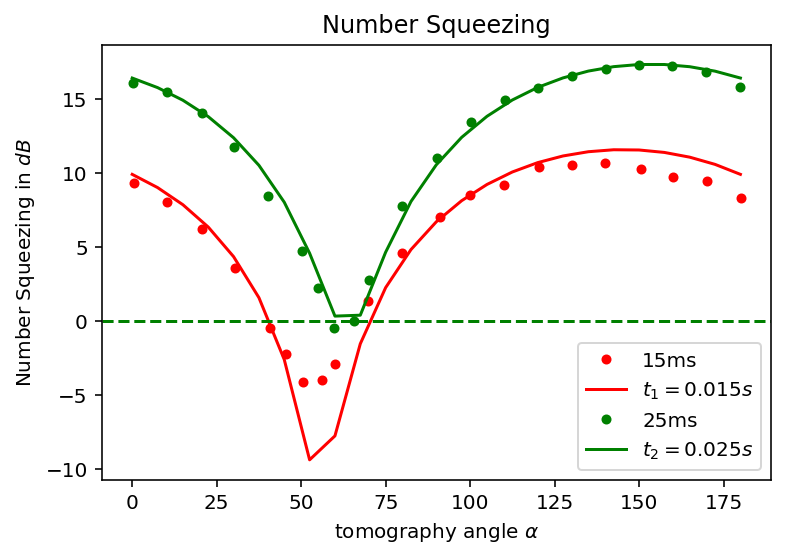

In [9]:
f, ax = plt.subplots()
ax.set_title("Number Squeezing")
ax.plot(data_strobel_15.dB, data_strobel_15.alpha, 'ro', label="15ms", markersize=4)
plt.plot(np.rad2deg(alphas), number_squeezing_factor_to_db(l/2, variances_1),'r-', label=fr"$t_1={t1}s$")
ax.plot(data_strobel_25.dB, data_strobel_25.alpha, 'go', label="25ms", markersize=4)
plt.plot(np.rad2deg(alphas), number_squeezing_factor_to_db(l/2, variances_2),'g-', label=fr"$t_2={t2}s$")
ax.axhline(y=0, color='g', linestyle='--')
ax.set_ylabel(r'Number Squeezing in $dB$')
ax.set_xlabel(r'tomography angle $\alpha$')
ax.legend()